# **Data Preprocessing , DataSet and DataLoaders**

In [1]:
import os
import xml.etree.ElementTree as ET
from glob import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import GPT2Tokenizer
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchvision import models
import math
from torch.cuda.amp import GradScaler, autocast
from transformers import get_cosine_schedule_with_warmup
from peft import get_peft_model, LoraConfig, TaskType
from tqdm import tqdm
import pandas as pd
import numpy as np
import gc
from transformers import BitsAndBytesConfig

2025-07-24 02:16:03.597237: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753323363.786273      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753323363.849502      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
%env TOKENIZERS_PARALLELISM = false

env: TOKENIZERS_PARALLELISM=false


# **Configuration**

In [3]:
XML_REPORTS_PATH = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_reports/ecgen-radiology/"
IMAGES_PATH = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/"

# Model & Training Params
TOKENIZER_NAME = "gpt2"
BATCH_SIZE = 8
MAX_SEQ_LENGTH = 512
IMAGE_SIZE = 224

# Data Split Params
VALID_SIZE = 0.10
TEST_SIZE = 0.10
RANDOM_STATE = 42

In [4]:
def clean_text(text):
    if text is None:
        return ""
    # More comprehensive text cleaning for medical reports
    text = text.lower().strip()
    text = text.replace('xxxx', '').replace('\n', ' ').replace('\r', ' ')
    # Remove multiple spaces
    text = ' '.join(text.split())
    return text

def create_data_manifest(xml_dir, img_dir):
    """
    Scans XMLs to create a list of all (image_path, report_text) pairs.
    Handles report duplication for multiple images.
    """
    manifest = []
    xml_files = glob(os.path.join(xml_dir, "*.xml"))
    print(f"Scanning {len(xml_files)} XML files to create manifest...")

    for xml_file in tqdm(xml_files, desc="Scanning XMLs"):
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            
            impression_node = root.find(".//AbstractText[@Label='IMPRESSION']")
            findings_node = root.find(".//AbstractText[@Label='FINDINGS']")
            impression_text = clean_text(impression_node.text if impression_node is not None else "")
            findings_text = clean_text(findings_node.text if findings_node is not None else "")
            full_report = f"findings: {findings_text} impression: {impression_text}"

            if not full_report.strip() or (not findings_text and not impression_text):
                continue
            
            image_nodes = root.findall(".//parentImage")
            for node in image_nodes:
                image_filename = node.get('id') + ".png"
                image_path = os.path.join(img_dir, image_filename)
                if os.path.exists(image_path):
                    manifest.append({
                        'image_path': image_path,
                        'report_text': full_report
                    })
        except Exception as e:
            print(f"Warning: Could not process {os.path.basename(xml_file)}. Error: {e}")
            
    return manifest

In [5]:
class IUXRayDataset(Dataset):
    """
    PyTorch Dataset for the IU X-Ray data.
    Processes data on-the-fly.
    """
    def __init__(self, manifest, tokenizer, image_transform, max_seq_length):
        self.manifest = manifest
        self.tokenizer = tokenizer
        self.transform = image_transform
        self.max_length = max_seq_length

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        item = self.manifest[idx]
        report_text = item['report_text']
        image_path = item['image_path']
        
        # --- Process Image ---
        # Note: Your project plan mentions a CNN backbone (ResNet) which expects 3 channels.
        # The .convert('RGB') handles this, even for grayscale images.
        image = Image.open(image_path).convert('RGB') 
        image_tensor = self.transform(image)
        
        # --- Process Text ---
        tokenized_report = self.tokenizer(
            report_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        # Squeeze to remove the batch dimension added by the tokenizer
        input_ids = tokenized_report['input_ids'].squeeze()
        attention_mask = tokenized_report['attention_mask'].squeeze()
        
        return {
            "image": image_tensor,
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            # We include these for potential visualization or debugging
            "report_text": report_text,
            "image_path": image_path
        }

# **Loaded Data Visualization**

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Scanning 3955 XML files to create manifest...


Scanning XMLs: 100%|██████████| 3955/3955 [00:25<00:00, 153.96it/s]


Data successfully split:
Total samples: 7430
Training set:  5944 samples
Validation set: 743 samples
Test set:      743 samples

PyTorch DataLoaders are ready!

--- Verifying a sample batch from the train_loader ---


Batch keys: dict_keys(['image', 'input_ids', 'attention_mask', 'report_text', 'image_path'])
Image tensor shape:      torch.Size([8, 3, 224, 224])
Input IDs tensor shape:  torch.Size([8, 512])
Attention mask shape:    torch.Size([8, 512])


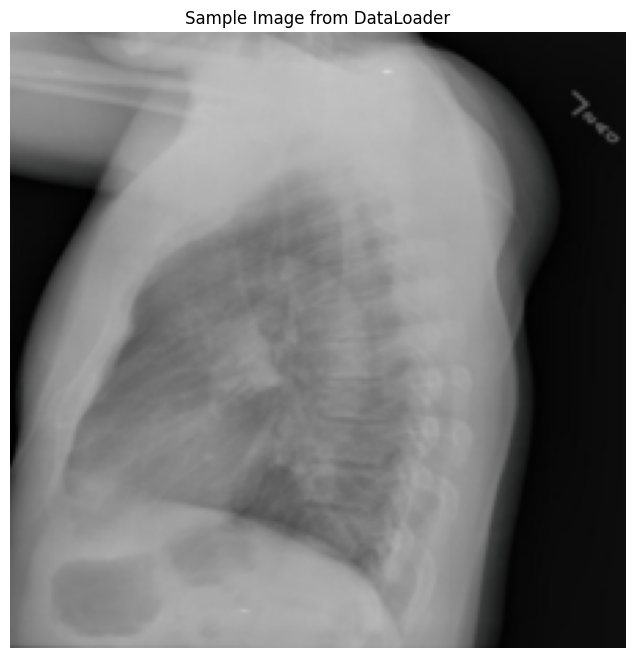


--- Sample Report from the same item ---
findings: normal heart. clear lungs. stable calcified granuloma left midlung. no pneumothorax. no pleural effusion. midline trachea. impression: normal chest exam.
------------------------------


In [6]:
tokenizer = GPT2Tokenizer.from_pretrained(TOKENIZER_NAME)

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

image_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


full_manifest = create_data_manifest(XML_REPORTS_PATH, IMAGES_PATH)


train_manifest, temp_manifest = train_test_split(
    full_manifest, 
    test_size=(VALID_SIZE + TEST_SIZE), 
    random_state=RANDOM_STATE
)

val_manifest, test_manifest = train_test_split(
    temp_manifest,
    test_size=(TEST_SIZE / (VALID_SIZE + TEST_SIZE)),
    random_state=RANDOM_STATE
)

print(f"\nData successfully split:")
print(f"Total samples: {len(full_manifest)}")
print(f"Training set:  {len(train_manifest)} samples")
print(f"Validation set: {len(val_manifest)} samples")
print(f"Test set:      {len(test_manifest)} samples")

# --- 3. Create Datasets and DataLoaders ---
train_dataset = IUXRayDataset(train_manifest, tokenizer, image_transform, MAX_SEQ_LENGTH)
val_dataset = IUXRayDataset(val_manifest, tokenizer, image_transform, MAX_SEQ_LENGTH)
test_dataset = IUXRayDataset(test_manifest, tokenizer, image_transform, MAX_SEQ_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("\nPyTorch DataLoaders are ready!")

# --- 4. Verification and Visualization ---
print("\n--- Verifying a sample batch from the train_loader ---")

# Fetch one batch
sample_batch = next(iter(train_loader))

print(f"Batch keys: {sample_batch.keys()}")
print(f"Image tensor shape:      {sample_batch['image'].shape}")
print(f"Input IDs tensor shape:  {sample_batch['input_ids'].shape}")
print(f"Attention mask shape:    {sample_batch['attention_mask'].shape}")

# Visualize one item from the batch
idx_to_show = random.randint(0, BATCH_SIZE - 1)

# Reverse the normalization for display
img_tensor = sample_batch['image'][idx_to_show]
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
img_display = (img_tensor * std) + mean
img_display = transforms.ToPILImage()(img_display)

report_display = sample_batch['report_text'][idx_to_show]

plt.figure(figsize=(8, 8))
plt.imshow(img_display)
plt.title("Sample Image from DataLoader")
plt.axis('off')
plt.show()

print("\n--- Sample Report from the same item ---")
print(report_display)
print("-" * 30)

# **Block -1 CNNFeatureExtractor --resnet101**

In [7]:
class CNNFeatureExtractor(nn.Module):
    """
    A CNN-based feature extractor using a pretrained ResNet.
    This module acts as the visual backbone of the model.

    Input:
        - images (torch.Tensor): A batch of images of shape [B, 3, 224, 224].

    Output:
        - features (torch.Tensor): A sequence of visual embeddings of shape [B, 49, 512].
    """
    def __init__(self, output_dim=512, trainable=False):
        super().__init__()
        
        # 1. Load a pretrained ResNet-101
        resnet = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
        
        # 2. Take the ResNet up to layer4 (i.e., excluding the final avgpool and fc layers).
        # The slice '[:-2]' achieves this. The output will be [B, 2048, 7, 7].
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        
        # 3. Define a projection layer (1x1 convolution) to reduce the channel
        # dimension from 2048 (output of ResNet's layer4) to our desired output_dim (512).
        self.projection = nn.Conv2d(2048, output_dim, kernel_size=1)
        
        # 4. Freeze the weights of the ResNet backbone if not trainable.
        # The new projection layer will remain trainable to learn the mapping.
        if not trainable:
            for param in self.features.parameters():
                param.requires_grad = False
                
        self.output_dim = output_dim

    def forward(self, images):
        """
        Forward pass to extract visual features.
        """
        # --- Step 1: Pass images through the ResNet backbone ---
        # Input:  [B, 3, 224, 224]
        # Output: [B, 2048, 7, 7]
        x = self.features(images)
        
        # --- Step 2: Apply the projection layer --- (THIS WAS THE MISSING STEP)
        # This reduces the channel dimension to our target.
        # Input:  [B, 2048, 7, 7]
        # Output: [B, 512, 7, 7]
        x = self.projection(x)
        
        # --- Step 3: Reshape for the sequence encoder ---
        B, C, H, W = x.shape
        
        # Flatten the spatial dimensions (H, W) into a sequence.
        # Shape becomes [B, 512, 49]
        x = x.view(B, C, H * W)
        
        # Permute to get the standard (Batch, Sequence Length, Channels) format.
        # Shape becomes [B, 49, 512]
        x = x.permute(0, 2, 1)
        
        return x

# **Testing of block 1**


--- Testing & Visualizing CNNFeatureExtractor with a REAL batch ---
Input tensor shape from DataLoader: torch.Size([8, 3, 224, 224])


Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 221MB/s]


Output feature tensor shape from model: torch.Size([8, 49, 512])

✅ Success! The output shape is correct.

Visualizing the output for one sample from the batch...


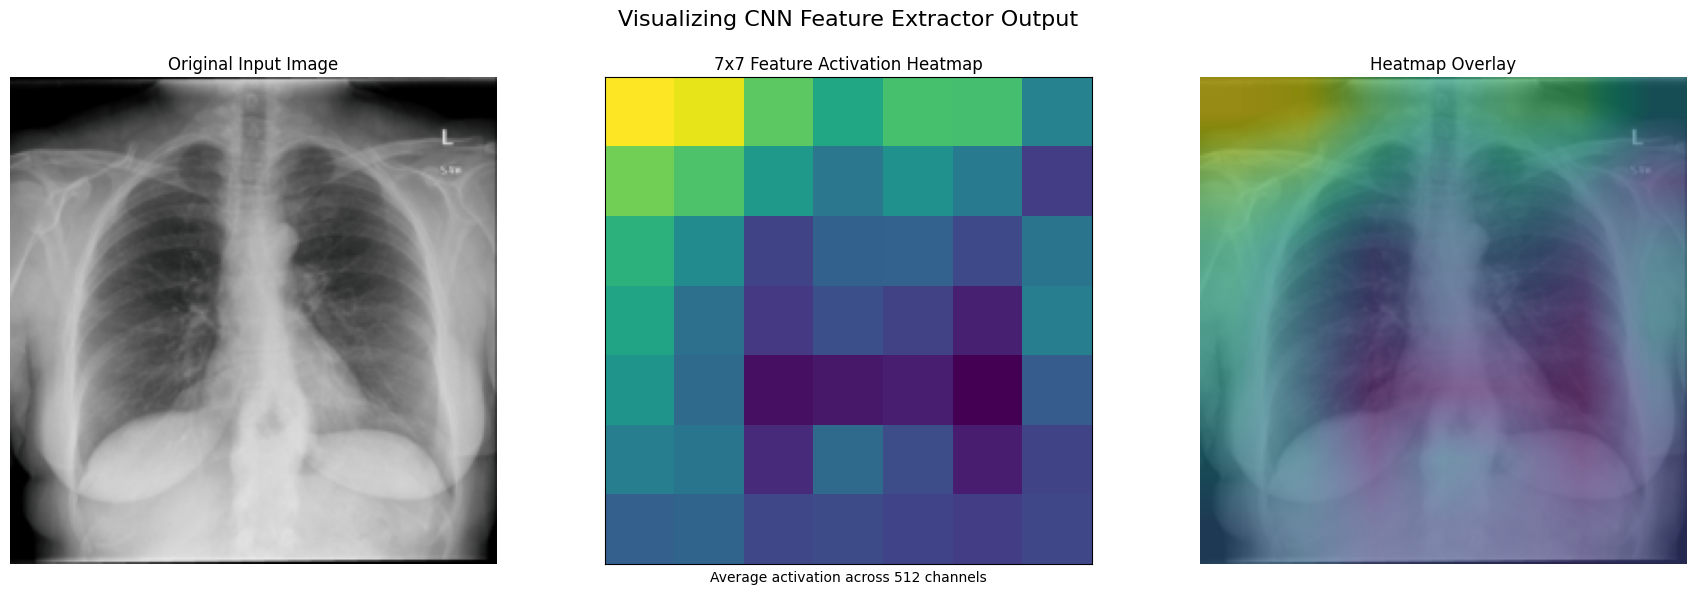

In [8]:
import torch.nn.functional as F # Needed for upsampling the heatmap

# (Your previous code for setting up DataLoaders should be here)
# ...

print("\n--- Testing & Visualizing CNNFeatureExtractor with a REAL batch ---")

# 1. Fetch a real batch from the DataLoader
sample_batch = next(iter(train_loader))
images_from_loader = sample_batch['image']
print(f"Input tensor shape from DataLoader: {images_from_loader.shape}")

# 2. Instantiate the model and get the output
visual_backbone = CNNFeatureExtractor()
visual_backbone.eval()

with torch.no_grad():
    output_features = visual_backbone(images_from_loader)
print(f"Output feature tensor shape from model: {output_features.shape}")

# 3. Verification
expected_shape = (BATCH_SIZE, 49, 512)
assert output_features.shape == expected_shape, \
    f"Shape mismatch! Expected {expected_shape}, but got {output_features.shape}"
print("\n✅ Success! The output shape is correct.")

# --- 4. Visualization of the Model's Output ---
print("\nVisualizing the output for one sample from the batch...")

# Choose one image from the batch to visualize (e.g., the first one)
idx_to_show = 0

# Get the features for this single image: shape [49, 512]
single_image_features = output_features[idx_to_show]

# --- Create the Feature Heatmap ---
# Calculate the mean activation for each patch across all 512 channels
# Shape goes from [49, 512] -> [49]
heatmap = single_image_features.mean(dim=1)

# Reshape the heatmap into a 2D grid
# Shape goes from [49] -> [7, 7]
heatmap_2d = heatmap.view(7, 7)

# --- Prepare the original image for display ---
# De-normalize the image tensor
original_image_tensor = images_from_loader[idx_to_show]
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
original_image_display = (original_image_tensor * std) + mean
original_image_display = transforms.ToPILImage()(original_image_display)

# --- Plotting ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle("Visualizing CNN Feature Extractor Output", fontsize=16)

# Plot 1: Original Image
ax1.imshow(original_image_display)
ax1.set_title("Original Input Image")
ax1.axis('off')

# Plot 2: Raw 7x7 Feature Heatmap
im = ax2.imshow(heatmap_2d, cmap='viridis')
ax2.set_title("7x7 Feature Activation Heatmap")
ax2.set_xlabel("Average activation across 512 channels")
#fig.colorbar(im, ax=ax2, orientation='horizontal', shrink=0.8)
ax2.set_xticks([])
ax2.set_yticks([])


# Plot 3: Overlay
# Upsample the 7x7 heatmap to 224x224 to match the image size
# We need to add batch and channel dimensions for interpolate: [1, 1, 7, 7]
upsampled_heatmap = F.interpolate(
    heatmap_2d.unsqueeze(0).unsqueeze(0),
    size=(IMAGE_SIZE, IMAGE_SIZE),
    mode='bilinear',
    align_corners=False
).squeeze()

ax3.imshow(original_image_display, cmap='gray')
ax3.imshow(upsampled_heatmap, cmap='viridis', alpha=0.6) # Overlay with transparency
ax3.set_title("Heatmap Overlay")
ax3.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **Encoder Block - Transformer encoder**

In [9]:
class TransformerBlock(nn.Module):
    """
    A standard Transformer Encoder block.
    
    Input:
        - src (torch.Tensor): Input sequence, shape [B, Seq Len, Dim].
    Output:
        - output (torch.Tensor): Processed sequence, shape [B, Seq Len, Dim].
    """
    def __init__(self, d_model=512, n_head=8, num_layers=2, 
                 dim_feedforward=2048, dropout=0.1):
        super().__init__()
        
        # Validate input dimensions
        assert d_model % n_head == 0, f"d_model ({d_model}) must be divisible by n_head ({n_head})"
        
        self.pos_encoder = PositionalEncoding(d_model, max_len=128)
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=n_head, 
            dim_feedforward=dim_feedforward, 
            dropout=dropout, 
            batch_first=True,
            norm_first=True  # Pre-norm for better training stability
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_layers
        )
        
        # Store config for debugging
        self.d_model = d_model
        self.n_head = n_head

    def forward(self, src):
        # Validate input
        assert src.size(-1) == self.d_model, \
            f"Expected feature dim {self.d_model}, got {src.size(-1)}"
        
        # Add positional encoding
        src_pos = self.pos_encoder(src)
        
        # Transformer layers
        output = self.transformer_encoder(src_pos)
        
        return output

# **Positional Encoding Block**

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=128):  # Increased for flexibility
        super().__init__()
        # Create positional encoding for batch_first format
        pe = torch.zeros(1, max_len, d_model)  # [1, max_len, d_model]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           (-math.log(10000.0) / d_model))
        
        pe[0, :, 0::2] = torch.sin(position * div_term)
        pe[0, :, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x shape: [batch_size, seq_len, d_model] (batch_first=True)
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :].to(x.device)

# **Testing of Transformer Encoder Block**


--- Verifying the TransformerBlock component ---
Input image batch shape: torch.Size([8, 3, 224, 224])


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


CNN output shape:          torch.Size([8, 49, 512])
Transformer output shape:  torch.Size([8, 49, 512])

✅ Success! The TransformerBlock is working correctly.

--- Visualizing TransformerBlock output ---


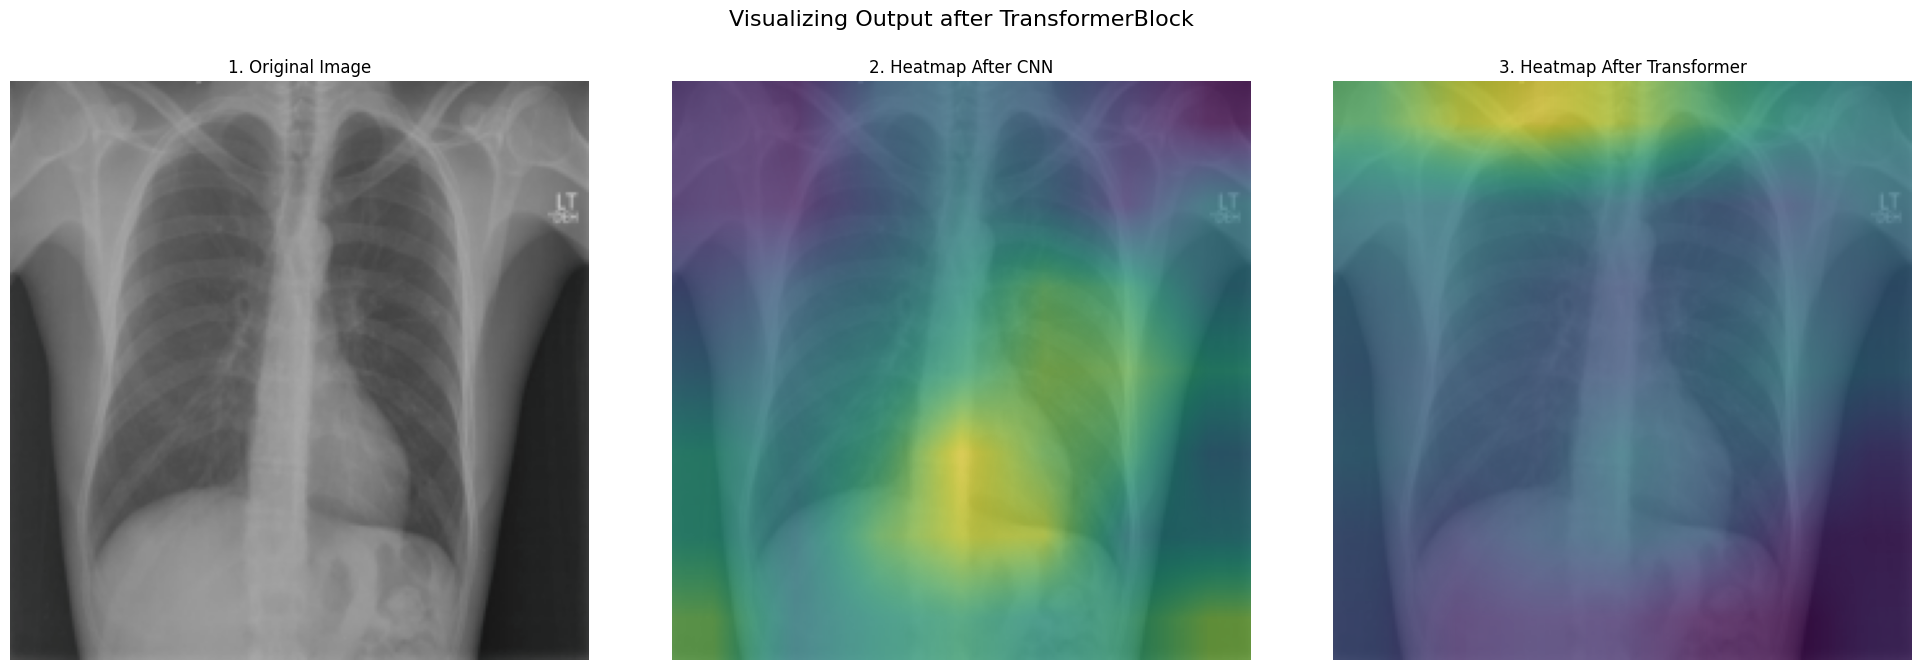

In [11]:
# --- Test and Visualize: DataLoader -> CNN -> TransformerBlock ---

print("\n--- Verifying the TransformerBlock component ---")

# 1. Fetch a real batch
try:
    sample_batch = next(iter(train_loader))
    images = sample_batch['image']
    print(f"Input image batch shape: {images.shape}")
except NameError:
    print("Error: 'train_loader' is not defined.")
    exit()

# 2. Instantiate and run pipeline up to the TransformerBlock
cnn_backbone = CNNFeatureExtractor()
transformer_only_encoder = TransformerBlock() # Using the separate TransformerBlock
cnn_backbone.eval()
transformer_only_encoder.eval()

with torch.no_grad():
    cnn_features = cnn_backbone(images)
    transformer_features = transformer_only_encoder(cnn_features)

print(f"CNN output shape:          {cnn_features.shape}")
print(f"Transformer output shape:  {transformer_features.shape}")

# 3. Verification
assert transformer_features.shape == (BATCH_SIZE, 49, 512), "Transformer output shape is incorrect!"
print("\n✅ Success! The TransformerBlock is working correctly.")

# 4. Visualization
print("\n--- Visualizing TransformerBlock output ---")
idx_to_show = 0

# Heatmap for CNN output
cnn_heatmap = cnn_features[idx_to_show].mean(dim=1).view(7, 7)
# Heatmap for Transformer output
transformer_heatmap = transformer_features[idx_to_show].mean(dim=1).view(7, 7)

# De-normalize original image
original_image_tensor = images[idx_to_show]
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
original_image = (original_image_tensor * std) + mean
original_image = transforms.ToPILImage()(original_image)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle("Visualizing Output after TransformerBlock", fontsize=16)

ax1.imshow(original_image)
ax1.set_title("1. Original Image")
ax1.axis('off')

# Plot overlay for CNN features
cnn_heatmap_up = F.interpolate(cnn_heatmap.unsqueeze(0).unsqueeze(0), size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False).squeeze()
ax2.imshow(original_image, cmap='gray')
ax2.imshow(cnn_heatmap_up, cmap='viridis', alpha=0.6)
ax2.set_title("2. Heatmap After CNN")
ax2.axis('off')

# Plot overlay for Transformer features
transformer_heatmap_up = F.interpolate(transformer_heatmap.unsqueeze(0).unsqueeze(0), size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False).squeeze()
ax3.imshow(original_image, cmap='gray')
ax3.imshow(transformer_heatmap_up, cmap='viridis', alpha=0.6)
ax3.set_title("3. Heatmap After Transformer")
ax3.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **Encoder Block - Mamba Block**

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MambaBlock(nn.Module):
    """
    A pure PyTorch implementation of a Mamba block. This version is designed to
    be hardware-agnostic and correctly implements the selective scan recurrence.
    """
    def __init__(self, d_model, d_state=16, d_conv=4, expand=2, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.d_conv = d_conv
        self.expand = expand
        self.d_inner = int(self.expand * self.d_model)

        # Input projection
        self.in_proj = nn.Linear(self.d_model, self.d_inner * 2, bias=False)
        
        # Causal convolution
        self.conv1d = nn.Conv1d(
            in_channels=self.d_inner, 
            out_channels=self.d_inner,
            kernel_size=d_conv, 
            bias=True, 
            groups=self.d_inner, 
            padding=d_conv - 1
        )

        # SSM parameter projections
        self.x_proj = nn.Linear(self.d_inner, self.d_state, bias=False)
        self.dt_proj = nn.Linear(self.d_state, self.d_inner, bias=True)
        
        # SSM parameters
        A = torch.arange(1, d_state + 1, dtype=torch.float32).repeat(self.d_inner, 1)
        self.A_log = nn.Parameter(torch.log(A))
        self.B_proj = nn.Linear(self.d_inner, self.d_state, bias=False)
        self.C_proj = nn.Linear(self.d_inner, self.d_state, bias=False)
        self.D = nn.Parameter(torch.ones(self.d_inner))

        # Output projection and normalization
        self.out_proj = nn.Linear(self.d_inner, self.d_model, bias=False)
        self.norm = nn.LayerNorm(self.d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Store residual
        residual = x
        batch_size, seq_len = x.size(0), x.size(1)
        
        # Input projection and split
        x_and_res = self.in_proj(x)
        x_branch, res_branch = x_and_res.split([self.d_inner, self.d_inner], dim=-1)

        # Causal convolution
        x_conv = x_branch.transpose(1, 2)
        x_conv = self.conv1d(x_conv)[:, :, :seq_len]
        x_conv = x_conv.transpose(1, 2)
        x_conv = F.silu(x_conv)

        # SSM parameters
        A = -torch.exp(self.A_log.float())
        delta_t = F.softplus(self.dt_proj(self.x_proj(x_conv)))
        B_ssm = self.B_proj(x_conv)  # Renamed to avoid collision
        C_ssm = self.C_proj(x_conv)
        
        # Selective scan
        h = torch.zeros(batch_size, self.d_inner, self.d_state, 
                       device=x.device, dtype=x.dtype)
        outputs = []
        
        for t in range(seq_len):
            delta_A = torch.exp(delta_t[:, t].unsqueeze(-1) * A)
            delta_B = delta_t[:, t].unsqueeze(-1) * B_ssm[:, t].unsqueeze(1)
            
            h = delta_A * h + delta_B
            y_t = (h * C_ssm[:, t].unsqueeze(1)).sum(dim=-1)
            outputs.append(y_t)
            
        y = torch.stack(outputs, dim=1)
        y = y + x_conv * self.D

        # Gated output
        y = y * F.silu(res_branch)
        y = self.out_proj(y)
        
        # Add residual connection and normalization
        return self.norm(residual + self.dropout(y))


# **Testing of Mamba Encoder Block**


--- Verifying the MambaBlock component ---
Input shape to MambaBlock: torch.Size([8, 49, 512])
MambaBlock output shape:   torch.Size([8, 49, 512])

✅ Success! The standalone MambaBlock is working correctly.

--- Visualizing the effect of a single MambaBlock ---


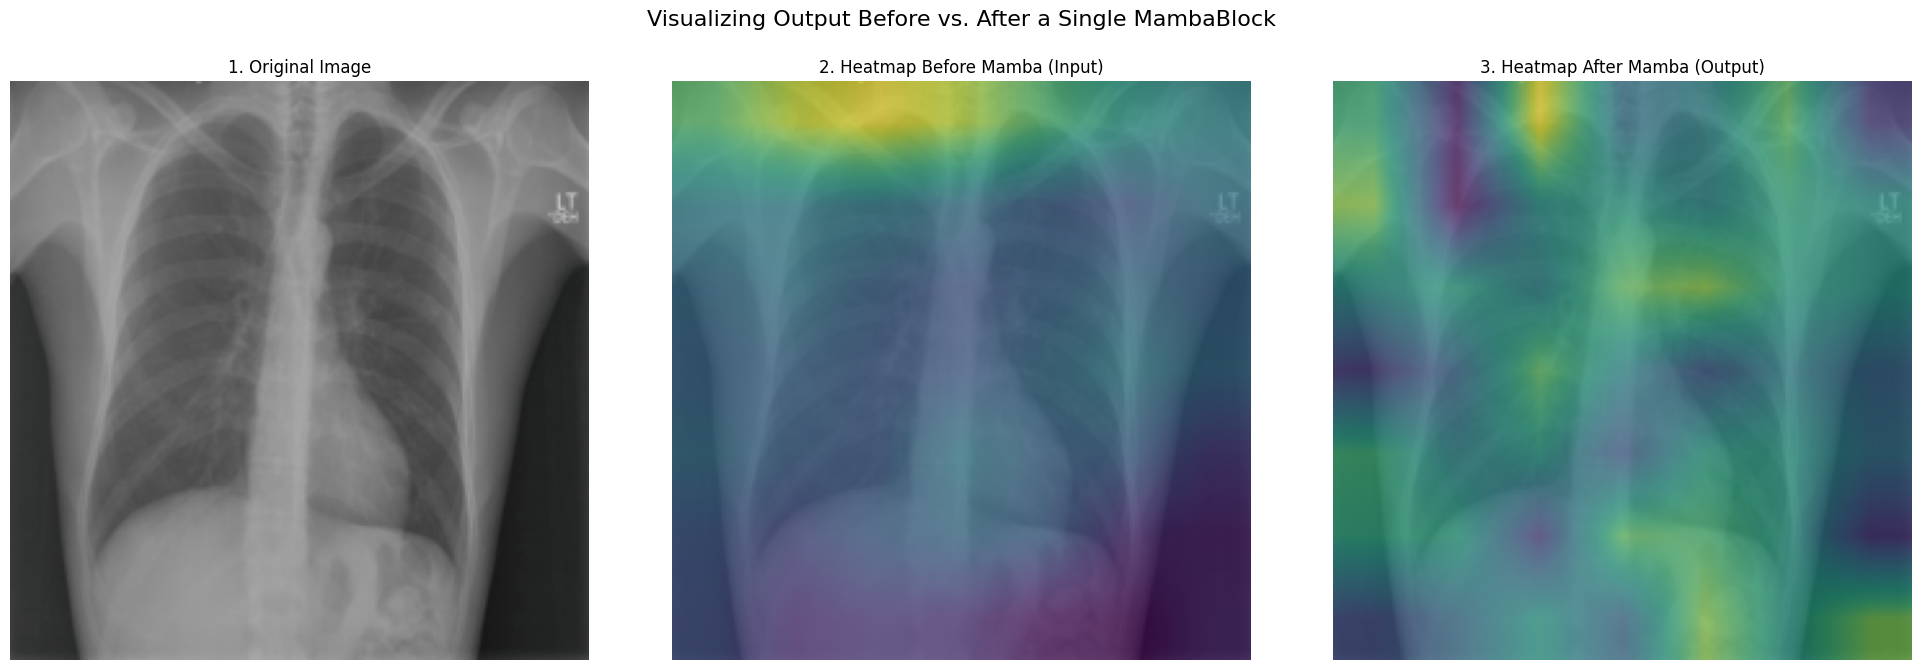

In [13]:
# --- Test and Visualize: (CNN -> Transformer) -> MambaBlock ---

import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

print("\n--- Verifying the MambaBlock component ---")

# 1. We need features that have been processed by the Transformer first.
# This code checks if 'transformer_features' already exists from a previous
# cell. If not, it generates it by running the prerequisite steps.
try:
    if 'transformer_features' not in locals() or 'images' not in locals():
        print("Running prerequisite steps to get Transformer features...")
        cnn_backbone = CNNFeatureExtractor()
        transformer_encoder = TransformerBlock()
        cnn_backbone.eval()
        transformer_encoder.eval()
        with torch.no_grad():
             # Make sure train_loader is defined
             sample_batch = next(iter(train_loader))
             images = sample_batch['image']
             cnn_features = cnn_backbone(images)
             # This is the output from the Transformer, which will be the input to the Mamba block
             transformer_features = transformer_encoder(cnn_features)
             print("Prerequisite features generated successfully.")

except NameError:
    print("Error: 'train_loader' or model classes are not defined. Please run previous cells.")
    exit()

print(f"Input shape to MambaBlock: {transformer_features.shape}")

# 2. Instantiate and run a single MambaBlock
mamba_layer = MambaBlock(d_model=512) # A single instance of our MambaBlock class
mamba_layer.eval()

with torch.no_grad():
    # Pass the output of the Transformer into the Mamba layer
    mamba_features = mamba_layer(transformer_features)

print(f"MambaBlock output shape:   {mamba_features.shape}")

# 3. Verification
assert mamba_features.shape == (BATCH_SIZE, 49, 512), "MambaBlock output shape is incorrect!"
print("\n✅ Success! The standalone MambaBlock is working correctly.")

# 4. Visualization
print("\n--- Visualizing the effect of a single MambaBlock ---")
idx_to_show = 0

# Heatmap for Transformer output (this is the INPUT to the Mamba block)
transformer_heatmap = transformer_features[idx_to_show].mean(dim=1).view(7, 7)
# Heatmap for Mamba output
mamba_heatmap = mamba_features[idx_to_show].mean(dim=1).view(7, 7)

# De-normalize the original image for display
original_image_tensor = images[idx_to_show]
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
original_image = (original_image_tensor * std) + mean
original_image = transforms.ToPILImage()(original_image)

# Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle("Visualizing Output Before vs. After a Single MambaBlock", fontsize=16)

# Plot 1: Original Image
ax1.imshow(original_image)
ax1.set_title("1. Original Image")
ax1.axis('off')

# Plot 2: Heatmap of the features BEFORE they enter the Mamba block
transformer_heatmap_up = F.interpolate(transformer_heatmap.unsqueeze(0).unsqueeze(0), size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False).squeeze()
ax2.imshow(original_image, cmap='gray')
ax2.imshow(transformer_heatmap_up, cmap='viridis', alpha=0.6)
ax2.set_title("2. Heatmap Before Mamba (Input)")
ax2.axis('off')

# Plot 3: Heatmap of the features AFTER they are processed by the Mamba block
mamba_heatmap_up = F.interpolate(mamba_heatmap.unsqueeze(0).unsqueeze(0), size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False).squeeze()
ax3.imshow(original_image, cmap='gray')
ax3.imshow(mamba_heatmap_up, cmap='viridis', alpha=0.6)
ax3.set_title("3. Heatmap After Mamba (Output)")
ax3.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **The Encoder - Main Block**

In [14]:
class TransMambaEncoder(nn.Module):
    """
    Hybrid encoder: Transformer (local) → Mamba (global) processing.
    """
    def __init__(self, d_model=512, n_head=8, num_transformer_layers=2, 
                 num_mamba_layers=2, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        
        self.transformer_block = TransformerBlock(
            d_model=d_model,
            n_head=n_head,
            num_layers=num_transformer_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout
        )
        
        self.mamba_layers = nn.ModuleList([
            MambaBlock(d_model=d_model, d_state=16, d_conv=4, expand=2, dropout=dropout) 
            for _ in range(num_mamba_layers)
        ])
        
        # Optional: Add a final normalization layer
        self.final_norm = nn.LayerNorm(d_model)

    def forward(self, src):
        # Local context via Transformer
        x = self.transformer_block(src)
        
        # Global context via Mamba layers
        for mamba_layer in self.mamba_layers:
            x = mamba_layer(x)
            
        return self.final_norm(x)


# **The Complete Encoder Testing**


--- Fetching a real batch from the DataLoader ---
Input image batch shape: torch.Size([8, 3, 224, 224])

--- Running the full vision encoder pipeline ---
CNN output shape:      torch.Size([8, 49, 512])
TransMamba final shape: torch.Size([8, 49, 512])

✅ Success! The full vision pipeline is working correctly.

--- Visualizing encoder outputs for one sample ---


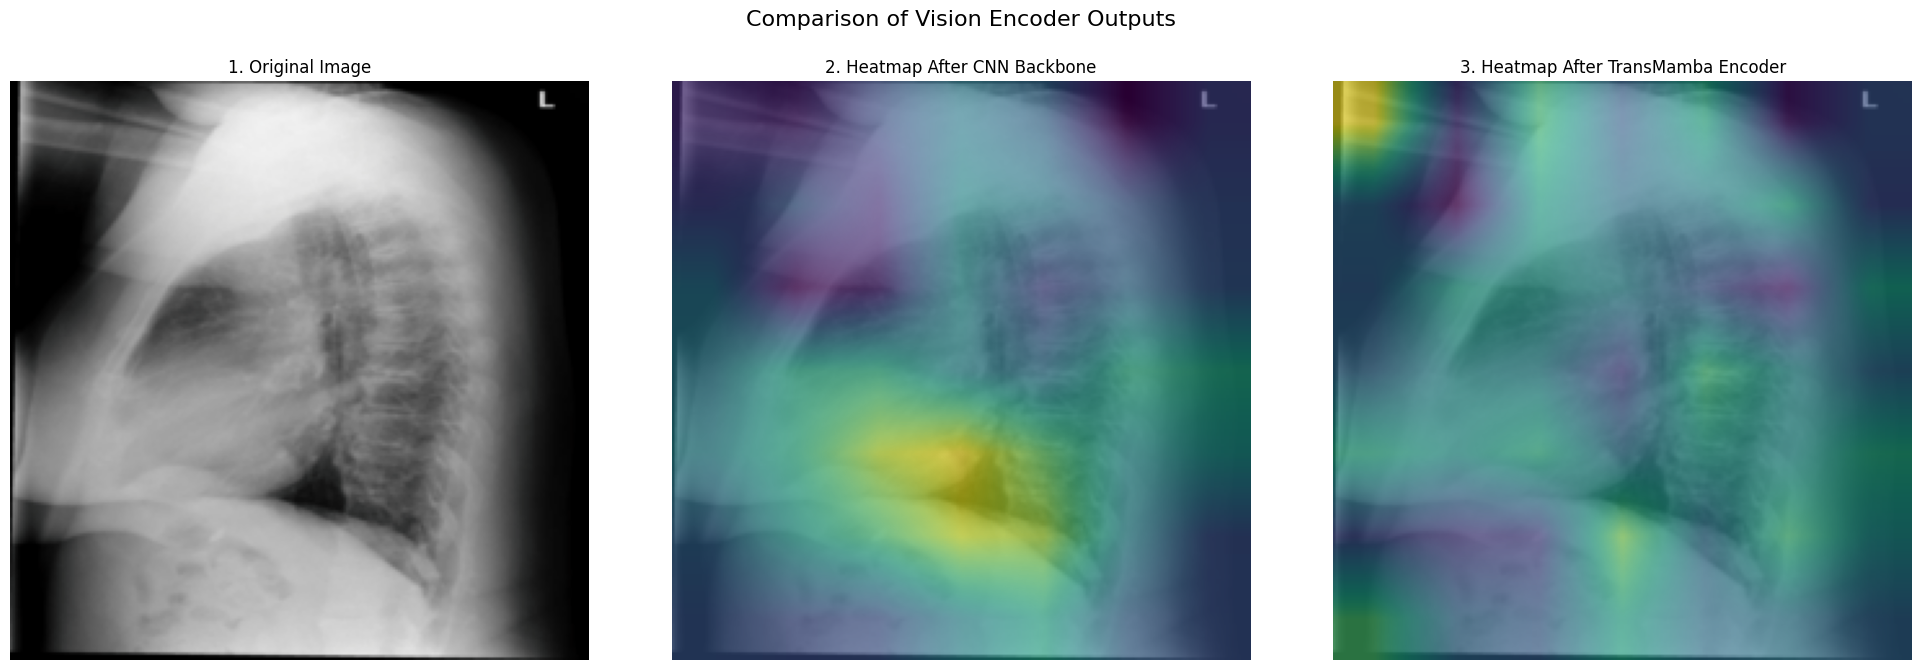

In [15]:
print("\n--- Fetching a real batch from the DataLoader ---")
# Make sure train_loader is defined and available
try:
    sample_batch = next(iter(train_loader))
    # In the previous combined script, the loader returned only images.
    # In the script with the full Dataset, it returns a dictionary. We'll handle both.
    if isinstance(sample_batch, dict):
        images = sample_batch['image']
    else:
        images = sample_batch
    
    print(f"Input image batch shape: {images.shape}")
except NameError:
    print("Error: 'train_loader' is not defined. Please ensure the data loading code has been run.")
    exit()


# 2. Instantiate and run the full vision encoder pipeline
print("\n--- Running the full vision encoder pipeline ---")
cnn_backbone = CNNFeatureExtractor()
hybrid_encoder = TransMambaEncoder()
cnn_backbone.eval()
hybrid_encoder.eval()

with torch.no_grad():
    cnn_features = cnn_backbone(images)
    final_features = hybrid_encoder(cnn_features)

print(f"CNN output shape:      {cnn_features.shape}")
print(f"TransMamba final shape: {final_features.shape}")

# 3. Verification
assert final_features.shape == (BATCH_SIZE, 49, 512), "Final shape is incorrect!"
print("\n✅ Success! The full vision pipeline is working correctly.")

# 4. Visualization
print("\n--- Visualizing encoder outputs for one sample ---")
idx_to_show = 0

# --- Create heatmap for the CNN output ---
cnn_heatmap = cnn_features[idx_to_show].mean(dim=1).view(7, 7)

# --- Create heatmap for the final TransMamba output ---
final_heatmap = final_features[idx_to_show].mean(dim=1).view(7, 7)

# --- De-normalize the original image for clear display ---
original_image_tensor = images[idx_to_show]
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
original_image = (original_image_tensor * std) + mean
original_image = transforms.ToPILImage()(original_image)

# --- Plotting all three stages ---
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle("Comparison of Vision Encoder Outputs", fontsize=16)

# Plot 1: Original Image
ax1.imshow(original_image)
ax1.set_title("1. Original Image")
ax1.axis('off')

# Plot 2: Heatmap Overlay after CNN Backbone
cnn_heatmap_up = F.interpolate(cnn_heatmap.unsqueeze(0).unsqueeze(0), size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False).squeeze()
ax2.imshow(original_image, cmap='gray')
ax2.imshow(cnn_heatmap_up, cmap='viridis', alpha=0.6)
ax2.set_title("2. Heatmap After CNN Backbone")
ax2.axis('off')

# Plot 3: Heatmap Overlay after TransMamba Encoder
final_heatmap_up = F.interpolate(final_heatmap.unsqueeze(0).unsqueeze(0), size=(IMAGE_SIZE, IMAGE_SIZE), mode='bilinear', align_corners=False).squeeze()
ax3.imshow(original_image, cmap='gray')
ax3.imshow(final_heatmap_up, cmap='viridis', alpha=0.6)
ax3.set_title("3. Heatmap After TransMamba Encoder")
ax3.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **Visual Alignment Adapter Block**

In [16]:
import torch
import torch.nn as nn

class VisualAlignmentAdapter(nn.Module):
    """
    A simple MLP to project the vision encoder's output dimension
    to match the language decoder's hidden dimension.
    
    Input:
        - x (torch.Tensor): Output from TransMambaEncoder, shape [B, 49, 512].
    Output:
        - encoder_output (torch.Tensor): Visual memory for the decoder, shape [B, 49, decoder_embed_dim].
    """
    def __init__(self, vision_dim=512, decoder_embed_dim=768):
        super().__init__()
        self.projection = nn.Linear(vision_dim, decoder_embed_dim)

    def forward(self, x):
        # x shape: [B, 49, 512]
        # Project the last dimension to match the decoder
        encoder_output = self.projection(x) # -> [B, 49, 768]
        return encoder_output



--- Testing the VisualAlignmentAdapter ---
Mock input shape to Adapter: torch.Size([4, 49, 512])
Final output shape from Adapter: torch.Size([4, 49, 768])

✅ Success! The adapter's output shape is correct.

--- Generating visualizations... ---


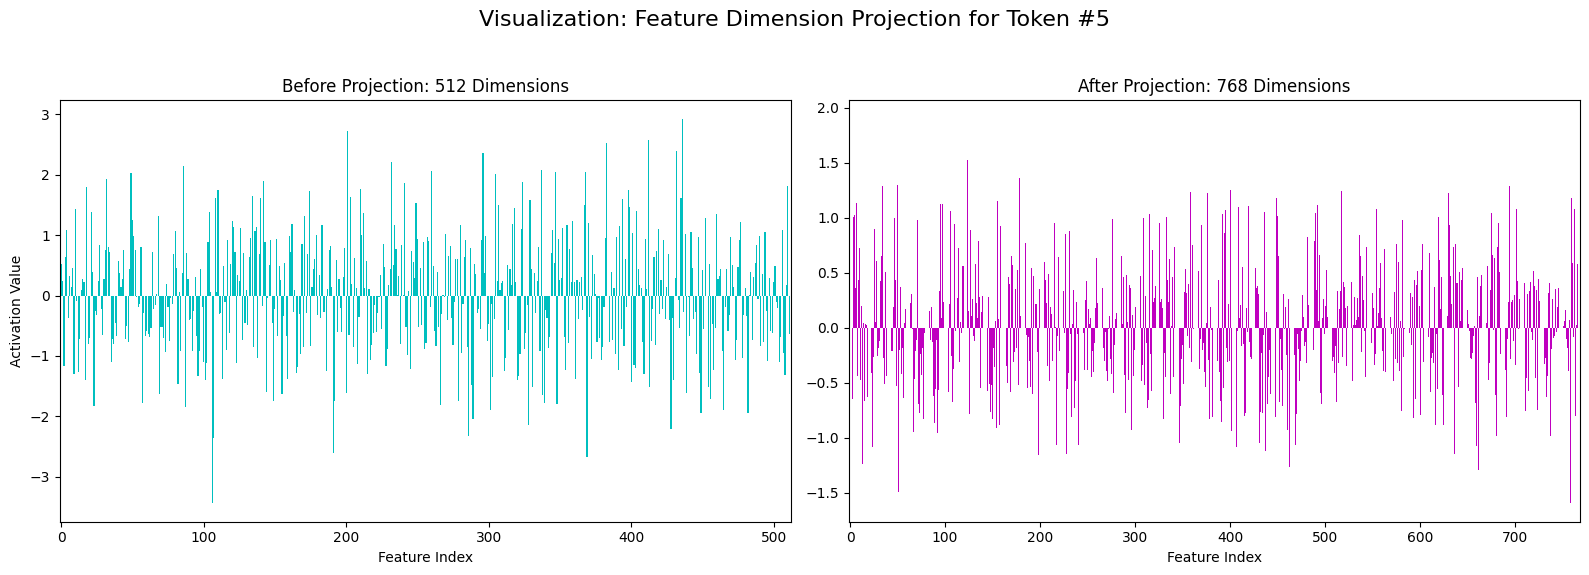

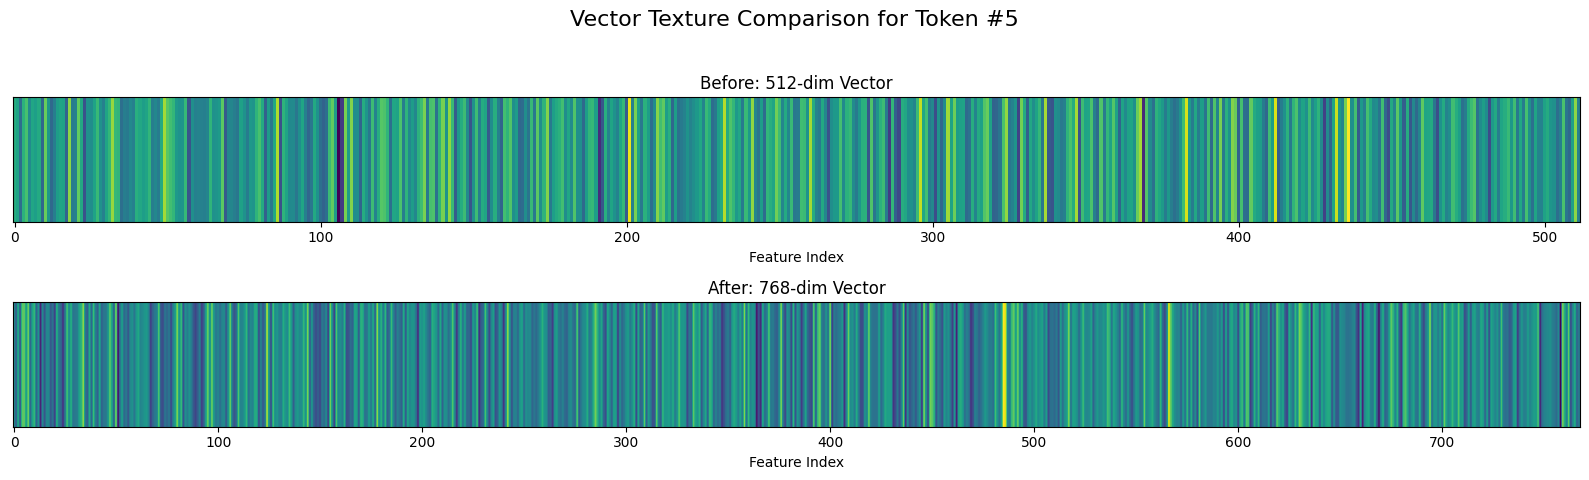

In [17]:
print("--- Testing the VisualAlignmentAdapter ---")

# 1. Define Hyperparameters
BATCH_SIZE = 4
VISION_DIM = 512
DECODER_DIM = 768
NUM_TOKENS = 49 # e.g., from a 7x7 feature map

# 2. Create a sample input tensor
# This simulates the output from the TransMambaEncoder
mock_encoder_output = torch.randn(BATCH_SIZE, NUM_TOKENS, VISION_DIM)
print(f"Mock input shape to Adapter: {mock_encoder_output.shape}")

# 3. Instantiate the adapter
# The dimensions must match the mock input and desired output
alignment_adapter = VisualAlignmentAdapter(vision_dim=VISION_DIM, decoder_embed_dim=DECODER_DIM)

# 4. Perform a forward pass
with torch.no_grad():
    final_visual_prefix = alignment_adapter(mock_encoder_output)

# 5. Verify the output shape
print(f"Final output shape from Adapter: {final_visual_prefix.shape}\n")
expected_shape = (BATCH_SIZE, NUM_TOKENS, DECODER_DIM)
assert final_visual_prefix.shape == expected_shape, f"Shape mismatch! Expected {expected_shape}, got {final_visual_prefix.shape}"
print("✅ Success! The adapter's output shape is correct.")


# --- VISUALIZATION ---
print("\n--- Generating visualizations... ---")
idx_to_show = 0       # Visualize the first sample in the batch
token_to_visualize = 5  # Pick the 5th token of the sequence

# Extract the vector for a single token before and after projection
before_projection_vector = mock_encoder_output[idx_to_show, token_to_visualize, :].numpy()
after_projection_vector = final_visual_prefix[idx_to_show, token_to_visualize, :].numpy()

# Create the plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle(f"Visualization: Feature Dimension Projection for Token #{token_to_visualize}", fontsize=16)

# Plot Before Projection
ax1.bar(range(VISION_DIM), before_projection_vector, color='c')
ax1.set_title(f"Before Projection: {VISION_DIM} Dimensions")
ax1.set_xlabel("Feature Index")
ax1.set_ylabel("Activation Value")
ax1.set_xlim(-1, VISION_DIM)

# Plot After Projection
ax2.bar(range(DECODER_DIM), after_projection_vector, color='m')
ax2.set_title(f"After Projection: {DECODER_DIM} Dimensions")
ax2.set_xlabel("Feature Index")
ax2.set_xlim(-1, DECODER_DIM)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# A second visualization using imshow to see the vector's "texture"
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 5))
fig.suptitle(f"Vector Texture Comparison for Token #{token_to_visualize}", fontsize=16)

ax1.imshow(before_projection_vector[np.newaxis, :], aspect="auto", cmap='viridis')
ax1.set_title(f"Before: {VISION_DIM}-dim Vector")
ax1.set_yticks([])
ax1.set_xlabel("Feature Index")

ax2.imshow(after_projection_vector[np.newaxis, :], aspect="auto", cmap='viridis')
ax2.set_title(f"After: {DECODER_DIM}-dim Vector")
ax2.set_yticks([])
ax2.set_xlabel("Feature Index")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# **Language Decoder Block - GPT2**

In [18]:
class GPT2Attention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.c_attn = nn.Linear(self.embed_dim, self.head_size * self.n_heads * 3,bias=True)
        self.scale = self.head_size ** -0.5
        
        self.register_buffer('mask',torch.tril(torch.ones(1,1,self.seq_len,self.seq_len)))
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        
    def forward(self, x):
        b,t,c = x.shape
        # q,k,v shape individually: batch_size x seq_len x embed_dim
        # we know that qk_t = q x k_t, where q=bxtxhead_dim, k_t=bxhead_timxt
        q,k,v = self.c_attn(x).chunk(3,dim=-1)
        q = q.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,t,self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = qk_t.masked_fill(self.mask[:,:,:t,:t]==0,float('-inf'))
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [19]:
class GPT2CrossAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.n_heads = config.num_heads
        assert self.embed_dim % self.n_heads == 0, 'embedding dimension by be divisible by number of heads'
        self.head_size = self.embed_dim // self.n_heads
        self.seq_len = config.seq_len
        
        self.q = nn.Linear(self.embed_dim,self.embed_dim)
        self.k = nn.Linear(self.embed_dim,self.embed_dim)
        self.v = nn.Linear(self.embed_dim,self.embed_dim)
        self.scale = self.head_size ** -0.5
        
        self.c_proj = nn.Linear(self.embed_dim, self.embed_dim, bias=True)
        
        self.attn_dropout = nn.Dropout(config.attention_dropout)
        self.resid_dropout = nn.Dropout(config.residual_dropout)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        
        
    def forward(self, q,k,v):
        b,t,c = q.shape
        
        q = self.q(q)
        k = self.k(k)
        v = self.v(v)
        
        q = q.view(b,q.size(1),self.n_heads,self.head_size).permute(0,2,1,3) # batch x n_heads x seq_len x head_dim
        k = k.view(b,k.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        v = v.view(b,v.size(1),self.n_heads,self.head_size).permute(0,2,1,3)
        
        qk_t = (q@k.transpose(-2,-1)) * self.scale
        qk_t = F.softmax(qk_t,dim=-1)
        weights = self.attn_dropout(qk_t)
        
        attention = weights @ v # batch x n_heads x t x head_size
        attention = attention.permute(0,2,1,3).contiguous().view(b,t,c) # batch x t x embed_dim
        
        out = self.c_proj(attention)
        out = self.resid_dropout(out)
        
        return out

In [20]:
class GPT2MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.mlp_ratio = config.mlp_ratio
        self.mlp_dropout = config.mlp_dropout
        
        self.c_fc = nn.Linear(self.embed_dim,self.embed_dim*self.mlp_ratio)
        self.c_proj = nn.Linear(self.embed_dim*self.mlp_ratio,self.embed_dim)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(self.mlp_dropout)
        
    def forward(self,x):
        x = self.c_fc(x)
        x = self.act(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [21]:
class GPT2Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.embed_dim = config.embed_dim
        self.ln_1 = nn.LayerNorm(self.embed_dim)
        self.attn = GPT2Attention(config)
        self.ln_2 = nn.LayerNorm(self.embed_dim)
        self.mlp = GPT2MLP(config)
        self.ln_3 = nn.LayerNorm(self.embed_dim)
        self.cross_attn = GPT2CrossAttention(config)
        
    def forward(self,x,enc_out):
        x = x+self.attn(self.ln_1(x))
        x = x+self.cross_attn(self.ln_2(x),enc_out,enc_out)
        x = x+self.mlp(self.ln_3(x))
        return x

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import warnings

# NOTE: Assuming CNNFeatureExtractor, TransMambaEncoder, VisualAlignmentAdapter, 
# and GPT2Block are defined elsewhere in your code.

class RadiologyReportGenerator(nn.Module):
    def __init__(self, vision_config, gpt2_config, device0, device1):
        super().__init__()

         # --- Store device assignments ---
        self.device0 = device0 # Device for Vision Encoder
        self.device1 = device1 # Device for Language Decoder
        
        self.config = gpt2_config
        
        # 1. Vision Encoder Pipeline
        self.cnn_extractor = CNNFeatureExtractor(output_dim=vision_config['embed_dim']).to(device0)
        self.trans_mamba = TransMambaEncoder(
            d_model=vision_config['embed_dim'],
            n_head=vision_config.get('n_head', 8),
            num_transformer_layers=vision_config.get('num_transformer_layers', 2),
            num_mamba_layers=vision_config.get('num_mamba_layers', 2)
        ).to(device0)
        self.visual_projector = VisualAlignmentAdapter(
            vision_dim=vision_config['embed_dim'],
            decoder_embed_dim=gpt2_config.embed_dim
        ).to(device0)
        
        # 2. GPT-2 Language Components
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(gpt2_config.vocab_size, gpt2_config.embed_dim),
            wpe = nn.Embedding(gpt2_config.seq_len, gpt2_config.embed_dim),
            drop = nn.Dropout(gpt2_config.emb_dropout),
            h = nn.ModuleList([GPT2Block(gpt2_config) for _ in range(gpt2_config.depth)]),
            ln_f = nn.LayerNorm(gpt2_config.embed_dim)
        )).to(device1)
        
        # 3. Language Modeling Head
        self.lm_head = nn.Linear(gpt2_config.embed_dim, gpt2_config.vocab_size, bias=False).to(device1)
        
        # Weight tying (standard in GPT-2)
        self.transformer.wte.weight = self.lm_head.weight
        
        # Store dimensions
        self.vision_dim = vision_config['embed_dim']
        self.decoder_dim = gpt2_config.embed_dim

    @classmethod    
    def from_pretrained(cls,vision_config, gpt2_config, device0,device1, pretrained_model_name='gpt2', 
                       freeze_pretrained=True, cross_attn_only=True):
        """
        Create model with pretrained GPT-2 weights and optimal freezing strategy.
        
        Args:
            vision_config: Configuration for vision encoder
            gpt2_config: Configuration for GPT-2 decoder  
            pretrained_model_name: GPT-2 variant ('gpt2', 'gpt2-medium', 'gpt2-large')
            freeze_pretrained: Whether to freeze pretrained components
            cross_attn_only: Whether to only train cross-attention (most efficient)
        """
        print(f"🚀 Loading RadiologyReportGenerator with pretrained {pretrained_model_name}...")
        
        # 1. Create model with random initialization first
        print(f"🚀 Initializing Model-Parallel Generator for devices {device0} and {device1}")
        model = cls(vision_config, gpt2_config, device0, device1)
        
        # 2. Load pretrained GPT-2 model
        print(f"📥 Loading pretrained weights from {pretrained_model_name}...")
        try:
            pretrained_gpt2 = GPT2LMHeadModel.from_pretrained(pretrained_model_name)
            pretrained_state_dict = pretrained_gpt2.state_dict()
        except Exception as e:
            print(f"❌ Failed to load {pretrained_model_name}: {e}")
            print("🔄 Falling back to 'gpt2' base model...")
            pretrained_gpt2 = GPT2LMHeadModel.from_pretrained('gpt2')
            pretrained_state_dict = pretrained_gpt2.state_dict()
        
        # 3. Get current model state dict
        model_state_dict = model.state_dict()
        
        # 4. Filter problematic keys
        pretrained_keys = [k for k in pretrained_state_dict.keys() 
                          if not k.endswith('.attn.masked_bias') 
                          and not k.endswith('.attn.bias')]
        
        # 5. Define layers that need weight transposition
        transposed_weights = [
            'attn.c_attn.weight', 'attn.c_proj.weight', 
            'mlp.c_fc.weight', 'mlp.c_proj.weight'
        ]
        
        # 6. Map and load pretrained weights
        mapping_success = 0
        mapping_failed = 0
        
        for pretrained_key in pretrained_keys:
            # Skip keys that don't exist in our custom architecture
            skip_keys = ['cross_attn', 'ln_3']  # These are our custom additions
            if any(skip in pretrained_key for skip in skip_keys):
                continue
                
            if pretrained_key in model_state_dict:
                pretrained_param = pretrained_state_dict[pretrained_key]
                model_param = model_state_dict[pretrained_key]
                
                try:
                    # Handle weight transposition for certain layers
                    if any(pretrained_key.endswith(w) for w in transposed_weights):
                        if pretrained_param.shape[::-1] == model_param.shape:
                            with torch.no_grad():
                                model_param.copy_(pretrained_param.t())
                            mapping_success += 1
                        else:
                            print(f"⚠️ Shape mismatch for {pretrained_key}")
                            mapping_failed += 1
                    else:
                        # Direct copy for matching shapes
                        if pretrained_param.shape == model_param.shape:
                            with torch.no_grad():
                                model_param.copy_(pretrained_param)
                            mapping_success += 1
                        else:
                            print(f"⚠️ Shape mismatch for {pretrained_key}")
                            mapping_failed += 1
                except Exception as e:
                    print(f"❌ Error loading {pretrained_key}: {e}")
                    mapping_failed += 1
        
        print(f"✅ Successfully loaded {mapping_success} pretrained parameters")
        if mapping_failed > 0:
            print(f"⚠️ Failed to load {mapping_failed} parameters (expected for custom layers)")
        
        # 7. Load the updated state dict
        model.load_state_dict(model_state_dict)
        
        # 8. Apply optimal freezing strategy
        if freeze_pretrained:
            if cross_attn_only:
                frozen_params = model.setup_cross_attention_only_training()
                print(f"🎯 Cross-Attention Only Training: {frozen_params:,} parameters frozen")
                print("🔥 Only cross-attention and visual projector are trainable!")
            else:
                frozen_params = model.freeze_pretrained_layers()
                print(f"🧊 Standard Freezing: {frozen_params:,} parameters frozen")
        
        print("🎉 Model ready for efficient fine-tuning!")
        return model

    def setup_cross_attention_only_training(self):
        """
        OPTIMAL STRATEGY: Freeze everything except cross-attention layers.
        This provides the best efficiency for vision-language fine-tuning.
        """
        frozen_params = 0
        trainable_params = 0
        
        # 1. Freeze ALL pretrained GPT-2 components
        components_to_freeze = [
            self.transformer.wte,    # Token embeddings
            self.transformer.wpe,    # Positional embeddings  
            self.transformer.drop,   # Embedding dropout
            self.transformer.ln_f,   # Final layer norm
            self.lm_head            # Language modeling head
        ]
        
        for component in components_to_freeze:
            for param in component.parameters():
                param.requires_grad = False
                frozen_params += param.numel()
        
        # 2. Freeze standard transformer components, keep cross-attention trainable
        for i, transformer_block in enumerate(self.transformer.h):
            # Freeze standard GPT-2 parts
            standard_components = [
                transformer_block.ln_1,   # Pre-attention layer norm
                transformer_block.attn,   # Self-attention
                transformer_block.ln_2,   # Pre-MLP layer norm  
                transformer_block.mlp     # Feed-forward network
            ]
            
            for component in standard_components:
                for param in component.parameters():
                    param.requires_grad = False
                    frozen_params += param.numel()
            
            # Keep cross-attention components trainable
            if hasattr(transformer_block, 'cross_attn'):
                for param in transformer_block.cross_attn.parameters():
                    param.requires_grad = True
                    trainable_params += param.numel()
                    
            if hasattr(transformer_block, 'ln_3'):
                for param in transformer_block.ln_3.parameters():
                    param.requires_grad = True
                    trainable_params += param.numel()
        
        # 3. Keep vision components trainable (optional: freeze encoder, keep projector)
        
        # Option A: Freeze entire vision encoder (most efficient)
        for param in self.cnn_extractor.parameters():
            param.requires_grad = False
            frozen_params += param.numel()
        for param in self.trans_mamba.parameters():
            param.requires_grad = False  
            frozen_params += param.numel()
            
        # Option B: Keep visual projector trainable (essential for alignment)
        for param in self.visual_projector.parameters():
            param.requires_grad = True
            trainable_params += param.numel()
        
        total_params = frozen_params + trainable_params
        print(f"📊 Training Strategy Summary:")
        print(f"   Trainable: {trainable_params:,} ({100*trainable_params/total_params:.1f}%)")
        print(f"   Frozen: {frozen_params:,} ({100*frozen_params/total_params:.1f}%)")
        print(f"   Total: {total_params:,}")
        
        return frozen_params

    def get_trainable_parameters(self):
        """Helper to check which parameters are actually trainable"""
        trainable = []
        frozen = []
        
        for name, param in self.named_parameters():
            if param.requires_grad:
                trainable.append((name, param.numel()))
            else:
                frozen.append((name, param.numel()))
        
        return trainable, frozen

    def print_training_setup(self):
        """Print detailed breakdown of trainable vs frozen parameters"""
        trainable, frozen = self.get_trainable_parameters()
        
        print("\n🔥 TRAINABLE PARAMETERS:")
        for name, count in trainable:
            print(f"   {name}: {count:,}")
        
        print(f"\n📊 SUMMARY:")
        total_trainable = sum([count for _, count in trainable])
        total_frozen = sum([count for _, count in frozen])
        total = total_trainable + total_frozen
        
        print(f"   Trainable: {total_trainable:,} ({100*total_trainable/total:.2f}%)")
        print(f"   Frozen: {total_frozen:,} ({100*total_frozen/total:.2f}%)")
        print(f"   Efficiency: {100*total_frozen/total:.1f}% parameters frozen!")

    # =========================================================================
    # --- FIX APPLIED HERE ---
    # =========================================================================
    def forward(self, images, input_ids, labels=None, attention_mask=None, **kwargs):
        """Forward pass with efficient cross-attention integration"""
        images = images.to(self.device0)
        # === VISION PROCESSING ===
        visual_features = self.cnn_extractor(images)
        encoded_features = self.trans_mamba(visual_features)
        visual_memory = self.visual_projector(encoded_features)
        visual_memory = visual_memory.to(self.device1)
        input_ids = input_ids.to(self.device1)
        
        # === TEXT PROCESSING ===
        token_embeddings = self.transformer.wte(input_ids)
        seq_len = input_ids.size(1)
        pos_ids = torch.arange(0, seq_len, device=self.device1)
        positional_embeddings = self.transformer.wpe(pos_ids)
        text_embeddings = self.transformer.drop(token_embeddings + positional_embeddings)
        
        # === INTEGRATED PROCESSING ===
        for transformer_block in self.transformer.h:
            text_embeddings = transformer_block(text_embeddings, visual_memory)
        
        text_embeddings = self.transformer.ln_f(text_embeddings)
        
        # === OUTPUT GENERATION ===
        logits = self.lm_head(text_embeddings)
        loss = None
        
        # If labels are provided (i.e., during training/validation), compute loss.
        if labels is not None:
            labels = labels.to(self.device1)
            loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
        
        # ALWAYS return a dictionary. During inference, 'loss' will be None.
        # This prevents the TypeError during generation.
        return {'loss': loss, 'logits': logits}


    def generate(self, images, input_ids, max_tokens=100, temperature=1.0, 
                do_sample=True, top_p=0.9, top_k=50,**kwargs):
        """Enhanced generation with better sampling strategies"""
        self.eval()
        # VISION ENCODING on device0
        images = images.to(self.device0)
        visual_features = self.cnn_extractor(images)
        encoded_features = self.trans_mamba(visual_features)  
        visual_memory = self.visual_projector(encoded_features)
        
        # Move inputs to device1 for generation loop
        visual_memory = visual_memory.to(self.device1)
        generated_sequence = input_ids.clone().to(self.device1)
        
        with torch.no_grad():
            for _ in range(max_tokens):
                # This call will now correctly receive a dictionary
                outputs = self.forward(images=images, input_ids=generated_sequence)
                logits = outputs['logits']
                next_token_logits = logits[:, -1, :] / temperature
                
                if do_sample:
                    # Apply top-k filtering
                    if top_k > 0:
                        indices_to_remove = next_token_logits < torch.topk(next_token_logits, top_k)[0][..., -1, None]
                        next_token_logits[indices_to_remove] = -float('inf')
                    
                    # Apply top-p filtering
                    if top_p < 1.0:
                        sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                        cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                        sorted_indices_to_remove = cumulative_probs > top_p
                        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                        sorted_indices_to_remove[..., 0] = 0
                        indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
                        next_token_logits[indices_to_remove] = -float('inf')
                    
                    probs = F.softmax(next_token_logits, dim=-1)
                    next_token = torch.multinomial(probs, num_samples=1)
                else:
                    next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
                
                generated_sequence = torch.cat([generated_sequence, next_token], dim=1)
                
        return generated_sequence

# **Trainer Class**

In [23]:
from pathlib import Path
from contextlib import nullcontext
import pandas as pd, numpy as np, torch, gc
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from PIL import Image
import math # Import math for perplexity calculation

class Trainer:
    """
    A Trainer class adapted for a MODEL-PARALLEL setup.

    This version does NOT move the model or batch data to a single device.
    It assumes the model's own `forward` pass handles placing tensors
    on their correct respective GPUs (e.g., cuda:0 and cuda:1).
    """
    def __init__(self, model: nn.Module,
                 train_loader,
                 val_loader,
                 tokenizer,
                 train_cfg: dict):

        print("Trainer initialised for Model-Parallel setup.")

        # --- Model and DataLoaders ---
        # FIX: Do NOT move the model to a single device.
        # It is assumed to be already split across GPUs during its initialization.
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader

        # --- Optimiser / Scheduler ---
        # The optimizer correctly finds parameters on their respective GPUs.
        optim_groups = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = torch.optim.AdamW(
            optim_groups,
            lr=train_cfg.get("lr", 5e-4),
            betas=(0.9, 0.999),
            weight_decay=train_cfg.get("wd", 0.01)
        )
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer,
            T_max=train_cfg.get("num_epochs", 3) * len(train_loader)
        )

        # --- Training Configuration ---
        self.tokenizer   = tokenizer
        self.cfg         = train_cfg
        self.grad_accum_steps = train_cfg.get("grad_accum", 1)
        self.precision   = train_cfg.get("precision", "bf16")
        self.use_amp     = self.precision in ["fp16", "bf16"]
        self.metrics_df  = pd.DataFrame(columns=["train_loss", "val_loss", "val_ppl"])
        self.clip_grad   = train_cfg.get("max_grad_norm", 1.0)
        
        # FIX: Use torch.amp.GradScaler for modern API
        self.scaler = torch.amp.GradScaler(device='cuda', enabled=(self.precision == "fp16"))
        
        Path(self.cfg.get("adapter_path", "./checkpoints")).mkdir(parents=True, exist_ok=True)


    # ==============================================================
    # ----------------------- Core Helpers -------------------------
    # ==============================================================

    def _step_optimizer(self):
        """Performs a single optimization step, including gradient clipping."""
        if self.precision == "fp16":
            self.scaler.unscale_(self.optimizer)
            
        if self.clip_grad:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_grad)
        
        self.scaler.step(self.optimizer)
        self.scaler.update()
        self.optimizer.zero_grad()
        self.scheduler.step()

    def _get_loss_item(self, loss: torch.Tensor):
        """Helper to get the scalar value of the loss."""
        return loss.detach().item()

    def _clear_memory(self):
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # ==============================================================
    # ------------------------ Train & Val -------------------------
    # ==============================================================

    def train_one_epoch(self, epoch: int):
        self.model.train()
        epoch_loss = 0.0
        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch+1} – Train")
    
        autocast_ctx = torch.amp.autocast(
            device_type='cuda',
            enabled=self.use_amp,
            dtype=torch.bfloat16 if self.precision == 'bf16' else torch.float16
        )

        for i, batch in enumerate(pbar):
            # FIX: Keep data on CPU. The model's forward pass is responsible
            # for moving tensors to the correct devices (cuda:0, cuda:1).
            images = batch["image"]
            text_inputs = {k: v for k, v in batch.items() if k != "image" and torch.is_tensor(v)}
            text_inputs["labels"] = text_inputs["input_ids"]
            
            with autocast_ctx:
                outputs = self.model(images=images, **text_inputs)
                loss = outputs['loss']
                if self.grad_accum_steps > 1:
                    loss = loss / self.grad_accum_steps

            # Backpropagation works automatically across devices
            self.scaler.scale(loss).backward()
            
            if (i + 1) % self.grad_accum_steps == 0 or (i + 1) == len(self.train_loader):
                self._step_optimizer()

            epoch_loss += self._get_loss_item(loss) * self.grad_accum_steps
            pbar.set_postfix({'loss': f"{self._get_loss_item(loss):.4f}"})
    
        self.metrics_df.loc[epoch, "train_loss"] = epoch_loss / len(self.train_loader)


    @torch.no_grad()
    def valid_one_epoch(self, epoch: int):
        self.model.eval()
        total_loss, steps = 0.0, 0
        pbar = tqdm(self.val_loader, desc=f"Epoch {epoch+1} – Val")
    
        for batch in pbar:
            # FIX: Also keep validation data on the CPU.
            images = batch["image"]
            text_inputs = {k: v for k, v in batch.items() if k != "image" and torch.is_tensor(v)}
            text_inputs["labels"] = text_inputs["input_ids"]
            
            with torch.amp.autocast(device_type='cuda', enabled=self.use_amp, dtype=torch.bfloat16 if self.precision == 'bf16' else torch.float16):
                outputs = self.model(images=images, **text_inputs)
                
            loss = self._get_loss_item(outputs['loss'])
            total_loss += loss
            steps += 1
            pbar.set_postfix({'loss': f"{loss:.4f}"})
    
        mean_loss = total_loss / steps
        self.metrics_df.loc[epoch, "val_loss"] = mean_loss
        try:
            self.metrics_df.loc[epoch, "val_ppl"]  = math.exp(mean_loss)
        except OverflowError:
            self.metrics_df.loc[epoch, "val_ppl"] = float('inf')
        return mean_loss

    def save_checkpoint(self, epoch: int, is_best: bool):
        """Saves the model checkpoint."""
        save_path = Path(self.cfg["adapter_path"])
        trainable_params = {k: v for k, v in self.model.state_dict().items() if v.requires_grad}
        
        if is_best:
            torch.save(trainable_params, save_path / "best_model.pth")
            print(f"✔️ New best val loss - saving model to {save_path / 'best_model.pth'}")
    def load_best_model(self,):
        save_path = Path(self.cfg["adapter_path"])
        sd = torch.load(save_path/'best_model.pth',map_location='cpu')
        self.model.load_state_dict(sd,strict=False)
            
    # ==============================================================
    # ---------------------- Training Loop -------------------------
    # ==============================================================

    def fit(self):
        best_val = float('inf')
        epochs   = self.cfg.get("num_epochs", 3)

        for epoch in range(epochs):
            self.train_one_epoch(epoch)
            val_loss = self.valid_one_epoch(epoch)

            trn = self.metrics_df.loc[epoch, "train_loss"]
            vl  = self.metrics_df.loc[epoch, "val_loss"]
            ppl = self.metrics_df.loc[epoch, "val_ppl"]
            print(f"\nEpoch {epoch+1}/{epochs} | "
                  f"Train Loss: {trn:.4f} | Val Loss: {vl:.4f} | Val PPL: {ppl:.2f}")

            is_best = val_loss < best_val
            if is_best:
                best_val = val_loss
                self.save_checkpoint(epoch, is_best=True)
            
            self._clear_memory()

        print(f"\n🎯 Training finished | Best Val Loss: {best_val:.4f}")
        return self.metrics_df

    # ==============================================================
    # --------------------- Inference Helper -----------------------
    # ==============================================================

    @torch.no_grad()
    def generate_report(self, image_path: str | Path,
                        max_new_tokens: int = 500,
                        temperature: float = 1.0,
                       ):
        """Generate a report for a single image."""
        self.model.eval()

        tfm = transforms.Compose([
            transforms.Resize((self.cfg.get("img_size", 224), self.cfg.get("img_size", 224))),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        image = tfm(Image.open(image_path).convert('RGB')).unsqueeze(0) # Keep on CPU

        start_token_id = self.tokenizer.bos_token_id or self.tokenizer.eos_token_id
        # Keep on CPU, model.generate should handle device placement
        input_ids = torch.tensor([[start_token_id]])

        # Assuming model.generate is also adapted for the model-parallel setup
        out_ids = self.model.generate(
            images=image,
            input_ids=input_ids,
            max_tokens=max_new_tokens,
            temperature=temperature
        )
        return self.tokenizer.decode(out_ids[0].to('cpu'), skip_special_tokens=True)

In [24]:
# 1. Define Configuration Classes
if torch.cuda.is_available() and torch.cuda.device_count() >= 2:
    print("✅ Found 2 GPUs. Setting up for model parallelism.")
    device0 = torch.device("cuda:0") # For Vision Encoder
    device1 = torch.device("cuda:1") # For Language Decoder
else:
    raise RuntimeError("This script requires at least 2 GPUs for model parallelism.")

class VisionConfig:
    def __init__(self):
        self.embed_dim = 512
        self.n_head = 8
        self.num_transformer_layers = 2
        self.num_mamba_layers = 2

class GPT2Config:
    def __init__(self):
        self.embed_dim = 768
        self.vocab_size = 50257  # GPT-2 vocabulary size
        self.seq_len = 512
        self.depth = 12  # GPT-2 base has 12 layers
        self.num_heads = 12
        self.emb_dropout = 0.1
        self.attention_dropout = 0.1
        self.residual_dropout = 0.1
        self.mlp_ratio = 4
        self.mlp_dropout = 0.1

# 2. Create Configuration Instances
vision_config = VisionConfig()
gpt2_config = GPT2Config()

# 3. Create Model with Pretrained Weights (Cross-Attention Only Training)
print("Creating RadiologyReportGenerator with pretrained GPT-2...")
model = RadiologyReportGenerator.from_pretrained(
    vision_config=vision_config.__dict__,
    device0=device0,  # <-- FIX: Pass the first GPU device
    device1=device1,
    gpt2_config=gpt2_config,
    pretrained_model_name='gpt2',  # or 'gpt2-medium' for better performance
    freeze_pretrained=True,
    cross_attn_only=True  # Most efficient training strategy
)

# 4. Verify Training Setup
model.print_training_setup()

# 5. Move to GPU if available (optional - Accelerator handles this)
# model = model.to('cuda' if torch.cuda.is_available() else 'cpu')


✅ Found 2 GPUs. Setting up for model parallelism.
Creating RadiologyReportGenerator with pretrained GPT-2...
🚀 Loading RadiologyReportGenerator with pretrained gpt2...
🚀 Initializing Model-Parallel Generator for devices cuda:0 and cuda:1
📥 Loading pretrained weights from gpt2...


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

⚠️ Shape mismatch for transformer.wpe.weight
✅ Successfully loaded 148 pretrained parameters
⚠️ Failed to load 1 parameters (expected for custom layers)
📊 Training Strategy Summary:
   Trainable: 28,760,832 (11.8%)
   Frozen: 215,824,960 (88.2%)
   Total: 244,585,792
🎯 Cross-Attention Only Training: 215,824,960 parameters frozen
🔥 Only cross-attention and visual projector are trainable!
🎉 Model ready for efficient fine-tuning!

🔥 TRAINABLE PARAMETERS:
   visual_projector.projection.weight: 393,216
   visual_projector.projection.bias: 768
   transformer.h.0.ln_3.weight: 768
   transformer.h.0.ln_3.bias: 768
   transformer.h.0.cross_attn.q.weight: 589,824
   transformer.h.0.cross_attn.q.bias: 768
   transformer.h.0.cross_attn.k.weight: 589,824
   transformer.h.0.cross_attn.k.bias: 768
   transformer.h.0.cross_attn.v.weight: 589,824
   transformer.h.0.cross_attn.v.bias: 768
   transformer.h.0.cross_attn.c_proj.weight: 589,824
   transformer.h.0.cross_attn.c_proj.bias: 768
   transformer.h

In [25]:

# Training configuration
train_cfg = dict(
    lr=5e-4,
    wd=0.01,
    num_epochs=10,
    grad_accum=4,
    adapter_path="./checkpoints",
    precision="bf16",
    img_size=224,
    max_grad_norm=1.0
)

# Now create trainer (this should work without NameError)
trainer = Trainer(model, train_loader, val_loader, tokenizer, train_cfg)



Trainer initialised for Model-Parallel setup.


In [26]:
metrics = trainer.fit()

Epoch 1 – Train:   0%|          | 0/743 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/autograd/graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1 – Val:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 1/10 | Train Loss: 0.9318 | Val Loss: 0.4071 | Val PPL: 1.50
✔️ New best val loss - saving model to checkpoints/best_model.pth


Epoch 2 – Train:   0%|          | 0/743 [00:00<?, ?it/s]

Epoch 2 – Val:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 2/10 | Train Loss: 0.4056 | Val Loss: 0.1796 | Val PPL: 1.20
✔️ New best val loss - saving model to checkpoints/best_model.pth


Epoch 3 – Train:   0%|          | 0/743 [00:00<?, ?it/s]

Epoch 3 – Val:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 3/10 | Train Loss: 0.2927 | Val Loss: 0.1146 | Val PPL: 1.12
✔️ New best val loss - saving model to checkpoints/best_model.pth


Epoch 4 – Train:   0%|          | 0/743 [00:00<?, ?it/s]

Epoch 4 – Val:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 4/10 | Train Loss: 0.2271 | Val Loss: 0.0744 | Val PPL: 1.08
✔️ New best val loss - saving model to checkpoints/best_model.pth


Epoch 5 – Train:   0%|          | 0/743 [00:00<?, ?it/s]

Epoch 5 – Val:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 5/10 | Train Loss: 0.1875 | Val Loss: 0.0535 | Val PPL: 1.05
✔️ New best val loss - saving model to checkpoints/best_model.pth


Epoch 6 – Train:   0%|          | 0/743 [00:00<?, ?it/s]

Epoch 6 – Val:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 6/10 | Train Loss: 0.1606 | Val Loss: 0.0429 | Val PPL: 1.04
✔️ New best val loss - saving model to checkpoints/best_model.pth


Epoch 7 – Train:   0%|          | 0/743 [00:00<?, ?it/s]

Epoch 7 – Val:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 7/10 | Train Loss: 0.1418 | Val Loss: 0.0379 | Val PPL: 1.04
✔️ New best val loss - saving model to checkpoints/best_model.pth


Epoch 8 – Train:   0%|          | 0/743 [00:00<?, ?it/s]

Epoch 8 – Val:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 8/10 | Train Loss: 0.1275 | Val Loss: 0.0293 | Val PPL: 1.03
✔️ New best val loss - saving model to checkpoints/best_model.pth


Epoch 9 – Train:   0%|          | 0/743 [00:00<?, ?it/s]

Epoch 9 – Val:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 9/10 | Train Loss: 0.1162 | Val Loss: 0.0252 | Val PPL: 1.03
✔️ New best val loss - saving model to checkpoints/best_model.pth


Epoch 10 – Train:   0%|          | 0/743 [00:00<?, ?it/s]

Epoch 10 – Val:   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 10/10 | Train Loss: 0.1080 | Val Loss: 0.0230 | Val PPL: 1.02
✔️ New best val loss - saving model to checkpoints/best_model.pth

🎯 Training finished | Best Val Loss: 0.0230


In [27]:
trainer.load_best_model()


Generating report using the Trainer's method...


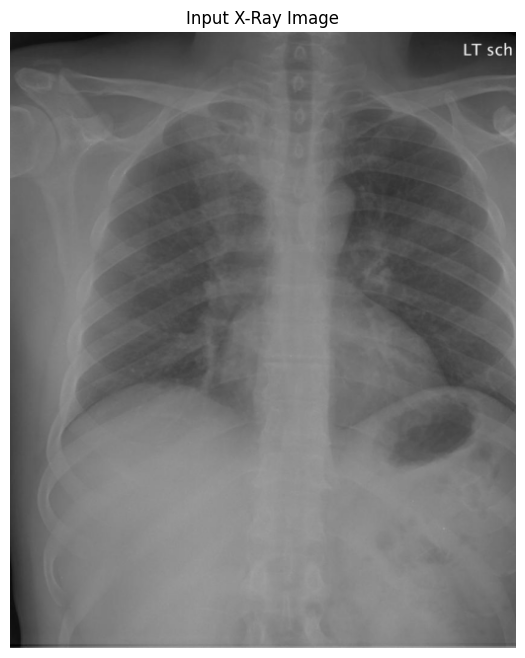

--------------------------------------------------
REPORT FOR IMAGE: /kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1000_IM-0003-1001.png
--------------------------------------------------

[GENERATED REPORT]
findings::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::,,,................ to the the the the the the the the the the the the the a a the the the lower lower lower low small near central 3 2 with cat al al at of or to the the was is,,.. toaasisusion volume examination clinicalographic disease abnorm ing.., of be of-as view view left will..... a 2 and the...iform enlarged pneum pneum pneum pneum pneum pneumneum normaloph lungs lung pulmonary pulmonary lungmonarymonary diagnosis pneum pneum abnorm exam with suspiciousmph the without blood, in, no further

[ACTUAL IMPRESSION (for comparison)]
The heart size and pulmonary vascularity are within normal limits.
--------------------------------------------------


In [28]:
image_path_to_test = "/kaggle/input/iu-chest-x-ray-dataset/NLMCXR_png/CXR1000_IM-0003-1001.png"

# A placeholder for the actual caption, for comparison
val_impression = "The heart size and pulmonary vascularity are within normal limits."

print("\nGenerating report using the Trainer's method...")

# Generate the caption using the trainer's helper method
generated_caption = trainer.generate_report(image_path_to_test, temperature=1.0)

# --- Display the results ---
if generated_caption:
    try:
        image_display = Image.open(image_path_to_test)
        plt.figure(figsize=(8, 8))
        plt.imshow(image_display, cmap='gray')
        plt.title("Input X-Ray Image")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Could not display image: {e}")

    print("-" * 50)
    print(f"REPORT FOR IMAGE: {image_path_to_test}")
    print("-" * 50)
    
    print("\n[GENERATED REPORT]")
    print(generated_caption)
    
    print("\n[ACTUAL IMPRESSION (for comparison)]")
    print(val_impression)
    print("-" * 50)